The pypokereval library used here can be found [here.](https://sourceforge.net/projects/fpdb/files/fpdb/pypoker-eval-win32/)

In [1]:
import os
import pokereval
import scipy.special
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
pe = pokereval.PokerEval()

In [3]:
numCards = 52
numRanks = 13
numSuits = 4
numHands = 1326 # (52 choose 2)
numVillainHands = 1225 # (50 choose 2)

suits = ['h', 'd', 'c', 's']
ranks = ['A', 'K', 'Q', 'J', 'T', '9', '8', '7', '6', '5', '4', '3', '2']
cards = [rnk + suit for suit in suits for rnk in ranks[::-1]] 
# NOTE: reversed ranks to match ordering in pokereval
# indices correspond to numerical representation of the cards
# in the pokereval module

In [4]:
handAsStrings = ['Ah', 'Jd']
boardAsStrings = ['8d', '6s', '3h', 'Kd', '__']

# Convention always work with numerical representation of hands and boards
# We will use card2string at the last minute only when displaying to user
# We will indicate strings in variale name whenever we break this convention
# ex: hand will be assumed to be numerical representation
# ex: handAsString will be assumed to be a string represntation of the card
# ex: handAsStrings = ['Ah', 'Jd']
# ex: hand = [12, 22]
# Note: hands run from 0 to 51 as enumerated by cards and 255 represents '__' (empty card)

hand = pe.string2card(handAsStrings)
board = pe.string2card(boardAsStrings)

In [5]:
# Time-complexity: O(n*m) where n and m are the lengths of the two lists
# Space-complexity: O(1)
def conflicts(cards1, cards2):
    """
    This function checks if two lists of cards conflict. It looks at every pair of
    cards in the input lists and returns True if it finds a match and False otherwise.
    
    Input: cards1 - a list of cards
           cards2 - a list of cards
    Output: True if any member of card1 is in card 2, False otherwise
    
    Examples:
    conflicts(['Ah', 'Ad'], ['Jh', 'Ah']) returns True
    conflicts(['Ah', 'Jd'], ['Kc', '10c']) returns False
    """
    for card in cards1:
        if card in cards2 and card != 255: # last condition ensures card is not the empty card
            return True
    return False


In [6]:
# Note the conflicts function is globablly accessible
# Bad organizational practice, we will fix this later in the project

print(conflicts(hand, board))
print(conflicts(pe.string2card(['Ah', '3h']), board))

False
True


In [7]:
pe.poker_eval?

In [8]:
villainHand = pe.string2card(['As', '4s'])
peresult = pe.poker_eval(game='holdem', pockets = [hand, villainHand], board = board)

In [9]:
def getEquityVsHand(hand, villainHand, board):
    """
    This function will call our PokerEval object to compute the equity
    of hero's hand verses villain's hand given the current board.
    
    Inputs:
        hand - a list of two cards in numerical format
        villainHand - a list of two cards in numerical format
        board - list of five cards describing the board in numerical format
        
    Output:
        all-in equity of hand vs villainHand on board
        unless any of hand, villainHand, and board conflict
        in which case the function returns -1
    """
    if conflicts(hand, villainHand) or conflicts(hand, board) or conflicts(villainHand, board):
        return -1
    peresult = pe.poker_eval(game='holdem', pockets=[hand, villainHand], board=board)
    numWins = peresult['eval'][0]['winhi']
    numTies = peresult['eval'][0]['tiehi']
    numRunouts = peresult['info'][0]
    return (numWins + 0.5 * numTies) / numRunouts

In [10]:
hand1 = pe.string2card(['Ah', 'Jd'])
hand2 = pe.string2card(['4c', '3s'])
getEquityVsHand(hand1, hand2, board)

0.13636363636363635

In [11]:
# EquityArray class organizes hand-vs-hand equities for a particular board.
class EquityArray:
    
    # Constructor
    # Input: b - list of numbers representing a board
    def __init__(self, b):
        self.board = b
        self.eArray = numpy.zeros((numCards, numCards, numCards, numCards))
        if os.path.isfile(self.getFilename()):
            self.eArray = np.load(self.getFilename())
        else:
            self.makeArray()
        return
            
    def makeArray(self):
        for i in range(numCards):
            for j in range(numCards):
                for a in range(numCards):
                    for b in range(numCards):
                        hand = [i, j]
                        villainHand = [a, b]
                        self.eArray[i][j][a][b] = getEquityVsHand(hand, villainHand, self.board)
        np.save(self.getFilename(), self.eArray)
        return
        
    def getFilename(self):
        boardStr = ''
        boardAsStrings = pe.card2string(self.board)
        for i in boardAsStrings:
            if i != '__':
                boardStr += i
        if boardStr == '':
            boardStr = 'preflop'
        boardStr += '.ea.npy'
        return boardStr

In [12]:
pe.card2string(board)

['8d', '6s', '3h', 'Kd', '__']

In [13]:
myEArray = EquityArray(board)
myEArray.getFilename()

'8d6s3hKd.ea.npy'

In [14]:
def getEquityVsHandFast(hand, villainHand, ea):
    return ea.eArray[hand[0]][hand[1]][villainHand[0]][villainHand[1]]

In [15]:
%timeit getEquityVsHand(hand, villainHand, board)

10000 loops, best of 3: 41.9 µs per loop


In [16]:
%timeit getEquityVsHandFast(hand, villainHand, myEArray)

The slowest run took 5.84 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 2.91 µs per loop


In [87]:
def setHandsWithConflicts(handArray, cardslist, num):
    """
    Modifies handArray so that every entry containing a card in cardslist is set to num.
    
    Inputs:
        handArray - numpy array of the same sort internal to the range class
        cardslist - a list of cards in numerical format
        num - a number (valid values between 0 and 1)
        
    Outputs:
        n/a
        
    Side-effects:
        modifies handArray to set the frequency 
        of all hands in cardslist to num
    """
    for c in cardslist:
        if c < numCards:
            handArray[c, :] = num
            handArray[:, c] = num
    return

def zeroHandsWithConflicts(handArray, cardslist):
    """
    This function modifies handArray so that every entry containing 
    a card in cardslist is set to zero.
    
    Inputs:
        handArray - numpy array of the same sort internal to the range class
        cardslist - a list of cards in numerical format
        
    Outputs:
        n/a
        
    Side-effects:
        modifies handArray to set the frequency 
        of all hands in cardslist to 0
    """
    setHandsWithConflicts(handArray, cardslist, 0)

In [81]:
# Make a separate file

# The Range class will describe a poker hand range
# The data stored in this class will be a numpy array
# of size numCards by numCards of numbers between 0
# and 1 each of which describes the fraction of a 
# particular hand combination.

# Note: there is some redundancy in this representation.
# Ex: (3h, 2h) and (2h, 3h) at [0][1] and [1][0]
# For this reason we only will access entries above
# the diagonal i.e. r[i][j] such that j > i.

# TBA: Figure out a more memory efficient representation
# of a range as described above.
# Ideas: sparse matrix or 1d array

class Range:
    def __init__(self, initFrac = None):
        self.r = np.zeros((numCards, numCards))
        if initFrac != None:
            self.setAllFracs(initFrac)
        return
            
    def getFrac(self, hand):
        """
        Input: a hand represented by a list of two numbers
        Output: the fraction of the hand contained in the range
        Side-effects: n/a
        """
        card1, card2 = hand
        if card1 > card2:
            card1, card2 = card2, card1
        return self.r[card1][card2]
    
    def getNumHands(self):
        """
        Input: n/a
        Output: total number of hand cominations contained in the range
        Side-effects: n/a
        """
        return sum(self.r)
    
    def getNumHandsWithoutConflicts(self, cardslist):
        """
        This function returns the number of hands in the Range object which
        do not contain any of the cards in cardslist
        
        Input:
            cardslist - a list of cards in numerical format
        Output:
            the number of hand combinations in thehand range that do not 
            conflict with any card in cardslist
        Side-effects:
            N/A
        """
        temp = numpy.copy(self.r)
        zeroHandsWithConflicts(temp, cardslist) # should I move this function inside the range class
        return sum(temp)
    
    def removeHandsWithConflicts(self, cardslist):
        """
        Removes hands from the range which conflict with cards in cardslist.
        
        Args:
            cardslist - a list of cards in numerical format
            
        Returns:
            N/A
        """
        zeroHandsWithConflicts(self.r, cardslist)
    
    def setFrac(self, hand, f):
        """
        This function will access the location in the Range object corresponding
        to hand and set the fraction (value of the range object) to f.
        
        Input:
            hand - a list of numbers describing the hand
            f -  a fraction between 0 and 1
        Output:
            N/A
        Side-effects:
            sets the fraction of hand on the calling range object to 1
        """
        card1, card2 = hand
        if card1 > card2:
            card1, card2 = card2, card1
        self.r[card1][card2] = f
        return
        
    def setAllFracs(self, num):
        """
        This function sets all fraction in the range object to the value num.
        
        Input:
            num - a fraction
        Output:
            N/A
        Side-effects:
            set the fraction of all hand combinations to num
        
        NB: This function does not perform any input validation.
        As such, input validation must be done before calling this
        function to ensure that scaling by num does not result in an
        invalid Range object, i.e. cause any fraction to be greater
        than 1 or less than 0."""
        for i in range(numCards):
            for j in range(i + 1, numCards):
                self.r[i][j] = num
        return
                
    def scaleFracs(self, num):
        """
        This function rescales all fractions in the range object
        by the value num.
        
        Input:
            num - a fraction
        Output:
            N/A
        Side-effects:
            scales the fraction of every hand comination in the
            Range object by num

        NB: This function does not perform any input validation.
        As such, input validation must be done before calling this
        function to ensure that scaling by num does not result in an
        invalid Range object, i.e. cause any fraction to be greater
        than 1 or less than 0.
        """
        self.r = self.r * num
        return
    
    def setRangeString(self, rangeString, value):
        """
        Sets hand combos specified by rangeString to input value.
        
        This function accepts a rangeString containing comma-separated
        preflop hand strings represented in the standard way.
        ex: XX denotes a pocket pair
            XY denotes two distinct values including suited/unsuited combos
            XYs only suited hands
            XYo only off suited combinations
            XaYb a specific single hand in a range
            
        Input:
            rangeString - a string containing comma-separated terms of the
                form XX, XY, XYs, XYo, XaXb
            value - a fraction between 0 and 1
        Output:
            N/A
        Side-effects:
            modifies calling range object by setting the hand combos
            specified by rangeString to the specified value.
        NB: This function assumes the input is in the valid format
        TBA: input validation
        """
        handStrs = rangeString.replace(' ', '').split(',')
        for hand in handStrs:
            if len(hand) == 2:
                # pocket pair (6 combos) or 2 distinct ranks (16 combos)
                rank1 = hand[0]
                rank2 = hand[1]
                for i in suits:
                    for j in suits:
                        if rank1 == rank2 and i == j:
                            continue
                        self.setFrac(pe.string2card([rank1+i, rank2+j]), value)
            elif len(hand) == 3:
                rank1 = hand[0]
                rank2 = hand[1]
                if hand[2] == 's':
                    for s in suits:
                        self.setFrac(pe.string2card([rank1+s, rank2+s]), value)
                elif hand[2] == 'o':
                    for i in range(numSuits):
                        for j in range(i+1, numSuits):
                            self.setFrac(pe.string2card([rank1+suits[i], rank2+suits[j]]), value)
                else:
                    print('Error. Invalid Input')
            elif len(hand) == 4:
                card1 = hand[0:2]
                card2 = hand[2:4]
                self.setFrac(pe.string2card([card1, card2]), value)
            else:
                # something is wrong
                print("Error. Invalid Input")
                
        
                
    # Input:
    #    rank1 - a string specifying a rank, ex: '2', 'T', 'A', etc.
    #    rank2 - a string specifying a rank
    #    suited - a Boolean indicating whether or not the hand is suited
    # Ouput: fraction of specified ambiguous hand contained in the range
    # Side-Effects: n/a
    #
    # Ambigiuous hands are things like:
    #    AKo - 12 combos
    #    AKs - 4 combos
    #    33 - 6 combos
    # Ex: if we call getAmbigFrac('A', 'K', True), then we're interested
    # in AKs and if the range contains 100% Akh, AKs, but 0 AKc, AKd, the
    # result should be 0.5 
    # Note: if we're interested in pocket pairs we should set suited=False
    def getAmbigFrac(self, rank1, rank2, suited):
        nHands = 0.0
        nFrac = 0.0
        
        # look at every specific hand combo corresponding to rank1, rank2, and suited
        for i in suits:
            for j in suits:
                card1 = rank1 + i
                card2 = rank2 + j
                if (suited and i != j) or (not suited and i==j):
                    continue
                if card1 == card2:
                    continue
                nHands += 1
                nFrac += self.getFrac(pe.string2card([card1, card2]))
        
        return nFrac / nHands
    
    # display a pokerstove-style handrange using svgs
    # TBD: fix formatting to center text in cell better
    def _repr_svg_(self):
        result = '<svg xmlns="http://www.w3.org/2000/svg" version = "1.1" width ="260" height = "260">'
        for i in range(numRanks):
            for j in range(numRanks):
                frac = self.getAmbigFrac(ranks[i], ranks[j], i > j)
                hexcolor = '#%02x%02x%02x' % (255*(1-frac), 255, 255*(1-frac))
                result += '<rect x="' + str(i*20) + '" y="' + str(j*20) + '" width="20" height="20" fill = "' + hexcolor + '"></rect>'
                #result += '<rect x="50%" y="50%" dominant-baseline="middle" text-anchor="middle" fill="black" font-size=12>' + ranks[i] + ranks[j] + '</text>'
                result += '<text x="' + str(i*20+2) + '" y="' + str((j+1)*20) + ' fill="black" font-size=12 >' + ranks[i] + ranks[j] + '</text>'
        result += '</svg>'
        return result
    
    # Input:
    #    villainRange - a Range object
    #    board - a list of numbers describing a board
    # Output: list of tuples of the form  (hand, equity) where
    #         hand is a list of integers itself and quity is the
    #         equity of the hand vs villainRange on the board. This
    #         output list will be sorted by equity (highest first).
    # Side-effects: n/a
    def getHandsSortedAndEquities(self, villainRange, board):
        ea = EquityArray(board)
        result = []
        for i in range(numCards):
            for j in range(i+1, numCards):
                hand = [i, j]
                if not conflicts(board, hand):
                    result.append((hand, getEquityVsRange(hand, villainRange, ea)))
                
        result.sort(key= lambda x: x[1], reverse=1)
        return result
    
    # It would be nice to be able to set range to top 68% of hands
    # preflop or something like this.
    # Input:
    #    fraction - a number describing fraction of all hands
    #    board - a list of numbers representing a board
    # Output: n/a
    # Side-effects: sets fraction of (appx.) the top fraction of hands
    #    (as ranked by equity vs any-two-cards) on board to 1, and the 
    #    rest to 0.
    def setToTop(self, fraction, board):
        rangeAllHands = Range()
        rangeAllHands.setAllFracs(1.0) # any-two-cards (ATC) range
        handsSorted = self.getHandsSortedAndEquities(rangeAllHands, board)
        
        numCardsLeft = numCards
        for c in board:
            if c < numCards:
                numCardsLeft -=1
        
        self.setAllFracs(0)
        
        for i in range(int(fraction * scipy.special.comb(numCardsLeft, 2))):
            self.setFrac(handsSorted[i][0], 1.0)    

In [19]:
# Input:
#    hand - a list of numbers
#    r - a Range object
#    ea - an EquityArray object
# Output:
def getEquityVsRange(hand, r, ea):
    herocard1, herocard2 = hand
    
    # Note ea.eArray is a numCards x numCards x numCards x numCards
    # shaped array. We need to start by grabbing the slice of the 
    # ea tensor corresponding to equity against hero's hand
    eqs = ea.eArray[herocard1, herocard2, : :]
    
    # NOTE: we need to avoid including in the calculation hands in r 
    # that conflict with the board
    villRange = np.copy(r.r)
    zeroHandsWithConflicts(villRange, hand + ea.board)
    
    return sum(np.multiply(eqs, villRange) / sum(villRange))

In [20]:
print(pe.card2string(hand))
print(pe.card2string(board))
bob = Range()
bob.setAllFracs(1.0)
getEquityVsRange(hand, bob, EquityArray(board))

['Ah', 'Jd']
['8d', '6s', '3h', 'Kd', '__']


0.45252525252525255

In [21]:
bob = Range()
bob.setAllFracs(1)
bob.setFrac(pe.string2card(['As', 'Ac']), 0.0)
bob.setFrac(pe.string2card(['As', 'Ad']), 0.0)
bob.setFrac(pe.string2card(['As', 'Ah']), 0.0)
display(bob)

In [22]:
print(pe.card2string(board))
bob = Range()
bob.setToTop(0.2, board)
display(bob)

['8d', '6s', '3h', 'Kd', '__']


In [23]:
# Testing setRangeString
bob = Range()
bob.setRangeString("AK,44,QJs", 1.0)
display(bob)

In [24]:
# Plotting Equity distributions
# The function below plots the equity distribution of r1 vs r2 on the board

# Input:
#    r1 - a Range object
#    r2 - a Range object
#    board - a list of cards in numerical format
def plotEqDistn(r1, r2, board):
    xs = []
    ys = []
    
    handCount = 0.0
    for hand in r1.getHandsSortedAndEquities(r2, board):
        # plot the hand at (handCount, equity) and (handCount + r1.getFrac(hand[0]), equity)
        xs.append(handCount)
        handCount += r1.getFrac(hand[0])
        xs.append(handCount)
        ys.append(hand[1])
        ys.append(hand[1])
    
    plot(xs, ys)

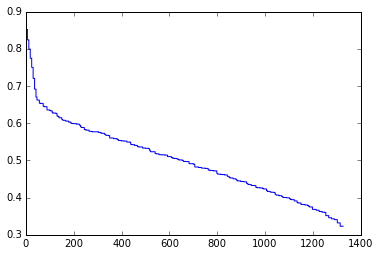

In [25]:
# preflop equity distribution of ATC vs ATC
pfBoard = pe.string2card(['__', '__', '__', '__', '__']) # preflop board
#pfEArray = EquityArray(pfBoard)
ATC = Range(1.0)
plotEqDistn(ATC, ATC, pfBoard)

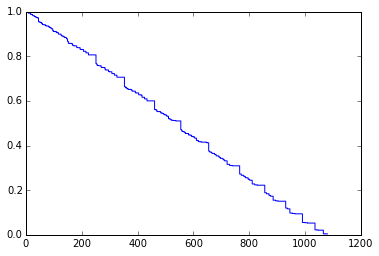

In [26]:
# Equity distribution on river
board = pe.string2card(['8d', '6s', '3h', 'Kd', 'Jd'])
range1 = Range(1.0)
range2 = Range(1.0)
plotEqDistn(range1, range2, board)

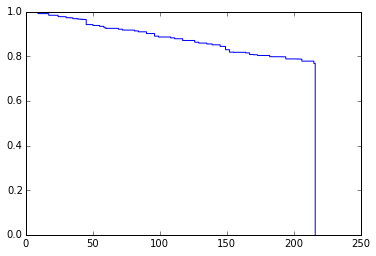

In [27]:
board = pe.string2card(['8d', '6s', '3h', 'Kd', 'Jd'])
range1 = Range(1.0)
range1.setToTop(0.2, board)
range2 = Range(1.0)
range2.setToTop(0.8, board)
plotEqDistn(range1, range2, board)

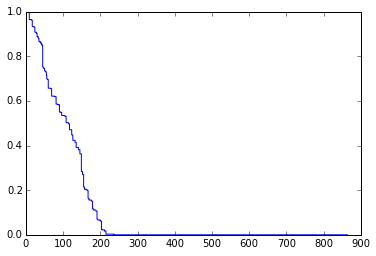

In [28]:
board = pe.string2card(['8d', '6s', '3h', 'Kd', 'Jd'])
range1 = Range(1.0)
range1.setToTop(0.2, board)
range2 = Range(1.0)
range2.setToTop(0.8, board)
plotEqDistn(range2, range1, board)

In [29]:
# Input:
#    r1 - a Range object
#    r2 - a Range ojbect
#    n - a positive integer
# Output: n/a
# Side-effect:
#    Modifies r1 to incorporate some amount (depending on n) of r2.
#    In particular, the output of every hand in r1 at the end of the function
#    will be given by:
#    (original amount) * (fraction depending on n) + (new amount) * (1 - fraction)
#    where the fraction becomes closer to 1 the higher n is.
def updateRange(r1, r2, n):
    fraction = 1 - 1 / (n + 2.0)
    for i in range(numCards):
        for j in range(i+1, numCards):
            hand = [i, j]
            r1.setFrac(hand, (r1.getFrac(hand)) * fraction + (r2.getFrac(hand)) * (1-fraction))
            

In [30]:
# Input: n/a
# Output: n/a
# Side-effects: display SB shoving range and BB calling range
def doShoveFoldGame():
    
    nIter = 200 # number of iterations for fictious play
    S = 10 # stack size in BB
    ea = EquityArray(pe.string2card(['__', '__', '__', '__', '__']))
    
    # guess initial ranges
    sbJamRange = Range()
    sbJamRange.setAllFracs(0.5) # not a good guess, this is deliberate
    bbCallRange = Range()
    bbCallRange.setAllFracs(0.5)
    
    for n in range(nIter):
        #display(sbJamRange)
        #display(bbCallRange)
        
        # solve for SB maximally exploitative strategy
        bestSBJamRange = Range()
        for i in range(numCards):
            for j in range(i+1, numCards):
                hand = [i, j]
                
                # The expected value of jamming is given by
                # (chance BB folds) * (S+1) + (chance BB calls) * equity * 2 * S
                # but we need to be careful to account for card removal effects
                
                bb_call_freq = bbCallRange.getNumHandsWithoutConflicts(hand) / numVillainHands
                equity = getEquityVsRange(hand, bbCallRange, ea)
                evJam = (1 - bb_call_freq) * (S+1) + (bb_call_freq) * equity * 2 * S
                evFold = S - 0.5
                if (evJam > evFold):
                    bestSBJamRange.setFrac(hand, 1)
                else:
                    bestSBJamRange.setFrac(hand, 0)
        
        # update SB strategy
        updateRange(sbJamRange, bestSBJamRange, n)
        
        # solve for BB maximally exploitative strategy
        bestBBCallRange = Range()
        for i in range(numCards):
            for j in range(i+1, numCards):
                hand = [i, j]
                equity = getEquityVsRange(hand, sbJamRange, ea)
                evCall = 2 * S * equity
                evFold = S - 1
                if (evCall > evFold):
                    bestBBCallRange.setFrac(hand, 1)
                else:
                    bestBBCallRange.setFrac(hand, 0)
                    
        # update BB strat
        updateRange(bbCallRange, bestBBCallRange, n)
        

        
        
    display(sbJamRange)
    display(bbCallRange)

In [31]:
doShoveFoldGame()

In [45]:
# DecPt - represents a decision point object:
#    player - a string decribing whose decision point it is
#             one of "SB", "BB", "Nature", or "Leaf
#    initial_sb_cip - small blind chips in pot before any decision is made
#                     at this point
#    initial_bb_cip - like above but for BB
#    eArray - an EquitiesArray describing the current board
#    parentAction - string describing the action that got us to this point
#                   one of: "bet", "fold", "check", "call" or board cards
#    newCardFreq - only used if parent action was new cards being dealt
#                  we don't want all new cards to have equaly probability
#                  of falling
class DecPt:
    def __init__(self, player, initial_sb_cip, initial_bb_cip, eArray, parentAction, newCardFreq = 1.0):
        self.player = player
        self.initial_sb_cip = initial_sb_cip
        self.initial_bb_cip = initial_bb_cip
        self.eArray = eArray
        self.parentAction = parentAction
        self.newCardFreq = newCardFreq
    
    # Input: player - a string that is either "SB" or "BB"
    # Output: chips in pot of player at beginning of decision point
    # Side-Effects: n/a
    def getPlayerCIP(self, player):
        if (player == "SB"):
            return sb_initial_cip
        elif (player == "BB"):
            return bb_initial_cip
        else:
            print "ERROR: DecPt.getPlayerCIP given invalid player: " + player

In [53]:
# A simple approach to a tree structure:
# Put all our decision points in a list (implicit numbering of them)
# Then, we need to keep track of parent/child relationships using two more arrays.
#    decPoints - name of this list
#    parents - the ith element of this array will contain the number of the
#              point which is the ith poin's parent. i.e. if we want to know
#              the ith point's parent, we access parent[i]
#    children - the ith element of this array will contain another array
#               containing the numbers of points which are the ith point's
#               children. i.e. if we want to know the ith point's children
#               we access children[i].
# Example:
#                 0       1       2       3       4
#     decPts: [pointA, pointB, pointC, pointD, pointE]
# children: [[], [], [], [1, 2], [0, 3]]
# parents: [4, 3, 3, 4, None]
# Note: we only need one list to tell us about parent/child relationships
#       because we can infer this relationship from one or the other
#       Nevertheless, storing them is more convenient than searching the whole
#       tree each time we need the other.

# When we make a new tree, we'll just gie it an effective stack size S,
# and a first decision point (called the root).
# Later, we will add additional decision points.
#
class Tree:
    def __init__(self, S, root):
        self.effStack = S
        self.decPts = [] # list of all decision pts in the tree
        self.children = []
        self.parents = []
        self.addDecPt(root, None) # (node, parents)
        
        
    # Inputs: n/a
    # Outputs: the number of decision points in the tree
    # Side-effects: n/a
    def getNumPoints(self):
        return len(self.decPts)
    
    # Inputs: n/a
    # Outputs: Effective stack at the beginning of the decision tree
    #          (corresponds to the beginning of the hand, i.e. neither player
    #           has money in the pot. No blinds, no bets made.)
    # Side-effects: n/a
    def getEffectiveStack(self):
        return self.effStack
        
    # Inputs:
    #    point: the new point (not previously in the tree)
    #    parent: a decision point already in the tree
    # Outputs: n/a
    # Side-effects: adds a new decision point to the tree
    def addDecPt(self, point, parent=None):
        self.decPts.append(point)
        self.children.append([])
        if (parent == None): # only true for the root node
            self.parents.append(None)
        else:
            parentIndex = self.decPts.index(parent)
            self.children[parentIndex].append(self.getNumPoints() - 1 )
            self.parents.append(parentIndex)
            
    # Args: N/A
    # Outputs: returns a PNG file displaying the tree.
    # Side-effects: N/A
    def _repr_png_(self):
        """Returns a .png file dipslaying the tree."""
        g = pydot.Dot(graph_type='digraph')
        
        # add nodes
        for i in range(self.getNumPoints()): # use i index in naming nodes
            node_label = str(i)  + ': ' + self.decPts[i].player \
                         + ' (' + str(self.decPts[i].initial_sb_cip) + ',' \
                         + str(self.decPts[i].initial_bb_cip) + ')'
            g.add_node(pydot.Node('node%d'%i, label=node_label))
        
        # add edges
        for i in range(self.getNumPoints()):
            for j in self.children[i]:
                g.add_edge(pydot.Edge('node%d'%i, 'node%d'%j, label=self.decPts[j].parentAction))
                
        return g.create(g.prog, 'png')

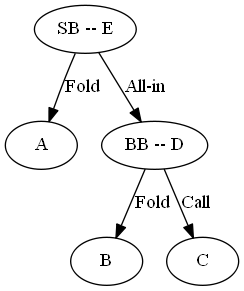

In [39]:
import pydot

g = pydot.Dot(graph_type="digraph")
g.add_node(pydot.Node('pointA', label='A'))
g.add_node(pydot.Node('pointB', label='B'))
g.add_node(pydot.Node('pointC', label='C'))
g.add_node(pydot.Node('pointD', label='BB -- D'))
g.add_node(pydot.Node('pointE', label='SB -- E'))

g.add_edge(pydot.Edge('pointE', 'pointA', label='Fold'))
g.add_edge(pydot.Edge('pointE', 'pointD', label='All-in'))
g.add_edge(pydot.Edge('pointD', 'pointB', label='Fold'))
g.add_edge(pydot.Edge('pointD', 'pointC', label='Call'))

from IPython.core.display import Image
Image(g.create(g.prog, 'png'))

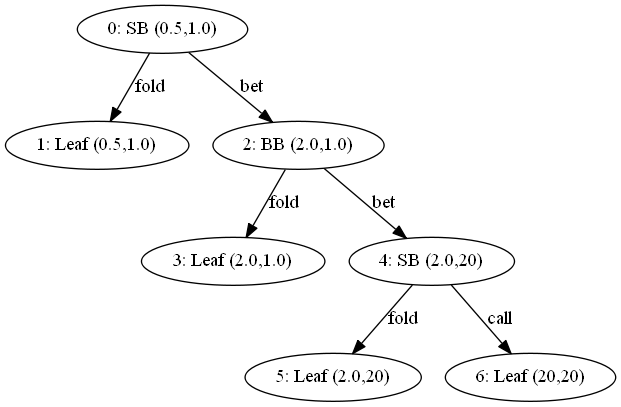

In [54]:
# min-raise shove preflop only
S = 20
preflopEArray = EquityArray(pe.string2card(['__', '__', '__', '__', '__']))
point0 = DecPt('SB', 0.5, 1.0, preflopEArray, "")
point1 = DecPt('Leaf', 0.5, 1.0, preflopEArray, "fold")
point2 = DecPt('BB', 2.0, 1.0, preflopEArray, "bet")
point3 = DecPt('Leaf', 2.0, 1.0, preflopEArray, "fold")
point4 = DecPt('SB', 2.0, 20, preflopEArray, "bet")
point5 = DecPt('Leaf', 2.0, 20, preflopEArray, "fold")
point6 = DecPt('Leaf', 20, 20, preflopEArray, "call")

minrShoveTree = Tree(S, point0)
minrShoveTree.addDecPt(point1, point0)
minrShoveTree.addDecPt(point2, point0)
minrShoveTree.addDecPt(point3, point2)
minrShoveTree.addDecPt(point4, point2)
minrShoveTree.addDecPt(point5, point4)
minrShoveTree.addDecPt(point6, point4)

minrShoveTree

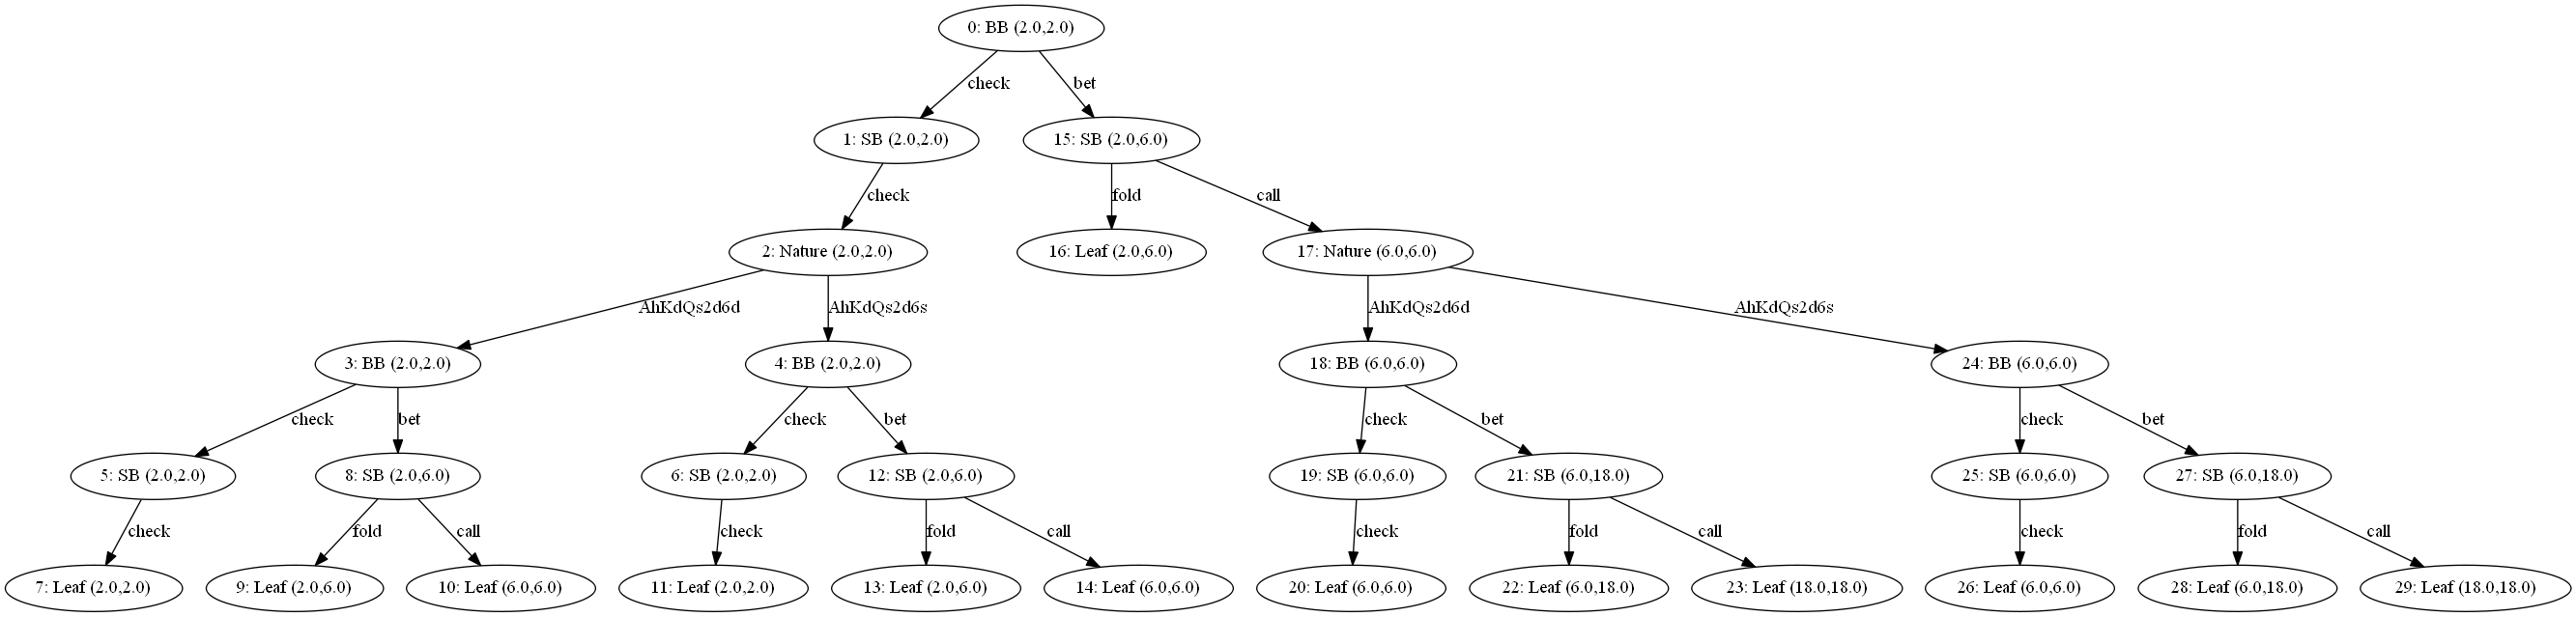

In [58]:
# More complex turn/river tree example

# Motivation:
# Suppose SB minraise preflop and is called.
# SB checks back AKQr flop in a singly raised pot.
# Flush draw comes on turn which gives BB a somewhat polarized range.
# Model with Polar vs bluff catcher decision tree and two possible river cards.
# i.e. we use an approximate tree w. BB driving betting action
# We also simplify by using only two possible river cards modelling two
# types: one that completes flush and one that does not.
# Note BB's bet sizing may seem large, but there are some game-theoretic
# reasons for using this behavior.

S = 20
turnEArray = EquityArray(pe.string2card(['Ah', 'Kd', 'Qs', '2d', '__']))
rivver1EArray = EquityArray(pe.string2card(['Ah', 'Kd', 'Qs', '2d', '6d']))
rivver2EArray = EquityArray(pe.string2card(['Ah', 'Kd', 'Qs', '2d', '6s']))

# create decision points
point0 = DecPt('BB', 2.0, 2.0, turnEArray, "")
point1 = DecPt('SB', 2.0, 2.0, turnEArray, "check")
point2 = DecPt('Nature', 2.0, 2.0, turnEArray, "check")
point3 = DecPt('BB', 2.0, 2.0, rivver1EArray, "AhKdQs2d6d")
point4 = DecPt('BB', 2.0, 2.0, rivver2EArray, "AhKdQs2d6s")
point5 = DecPt('SB', 2.0, 2.0, rivver1EArray, "check")
point6 = DecPt('SB', 2.0, 2.0, rivver2EArray, "check")
point7 = DecPt('Leaf', 2.0, 2.0, rivver1EArray, "check")
point8 = DecPt('SB', 2.0, 6.0, rivver1EArray, "bet")
point9 = DecPt('Leaf', 2.0, 6.0, rivver1EArray, "fold")
point10 = DecPt('Leaf', 6.0, 6.0, rivver1EArray, "call")
point11 = DecPt('Leaf', 2.0, 2.0, rivver2EArray, "check")
point12 = DecPt('SB', 2.0, 6.0, rivver2EArray, "bet")
point13 = DecPt('Leaf', 2.0, 6.0, rivver2EArray, "fold")
point14 = DecPt('Leaf', 6.0, 6.0, rivver2EArray, "call")
point15 = DecPt('SB', 2.0, 6.0, turnEArray, "bet")
point16 = DecPt('Leaf', 2.0, 6.0, turnEArray, "fold")
point17 = DecPt('Nature', 6.0, 6.0, turnEArray, "call")
point18 = DecPt('BB', 6.0, 6.0, rivver1EArray, "AhKdQs2d6d")
point19 = DecPt('SB', 6.0, 6.0, rivver1EArray, "check")
point20 = DecPt('Leaf', 6.0, 6.0, rivver1EArray, "check")
point21 = DecPt('SB', 6.0, 18.0, rivver1EArray, "bet")
point22 = DecPt('Leaf', 6.0, 18.0, rivver1EArray, "fold")
point23 = DecPt('Leaf', 18.0, 18.0, rivver1EArray, "call")
point24 = DecPt('BB', 6.0, 6.0, rivver2EArray, "AhKdQs2d6s")
point25 = DecPt('SB', 6.0, 6.0, rivver2EArray, "check")
point26 = DecPt('Leaf', 6.0, 6.0, rivver2EArray, "check")
point27 = DecPt('SB', 6.0, 18.0, rivver2EArray, "bet")
point28 = DecPt('Leaf', 6.0, 18.0, rivver2EArray, "fold")
point29 = DecPt('Leaf', 18.0, 18.0, rivver2EArray, "call")

T = Tree(S, point0)
# add parent/child relationships
T.addDecPt(point1, point0)
T.addDecPt(point2, point1)
T.addDecPt(point3, point2)
T.addDecPt(point4, point2)
T.addDecPt(point5, point3)
T.addDecPt(point6, point4)
T.addDecPt(point7, point5)
T.addDecPt(point8, point3)
T.addDecPt(point9, point8)
T.addDecPt(point10, point8)
T.addDecPt(point11, point6)
T.addDecPt(point12, point4)
T.addDecPt(point13, point12)
T.addDecPt(point14, point12)
T.addDecPt(point15, point0)
T.addDecPt(point16, point15)
T.addDecPt(point17, point15)
T.addDecPt(point18, point17)
T.addDecPt(point19, point18)
T.addDecPt(point20, point19)
T.addDecPt(point21, point18)
T.addDecPt(point22, point21)
T.addDecPt(point23, point21)
T.addDecPt(point24, point17)
T.addDecPt(point25, point24)
T.addDecPt(point26, point25)
T.addDecPt(point27, point24)
T.addDecPt(point28, point27)
T.addDecPt(point29, point27)

T

In [77]:
# A strategy tells us what each player does in each spot
# i.e. ranges for each possible action
# This means we need a way of keeping track of these
# i.e. create a new class.

# Strategy: a range for every action the player could take
# Strategy is a pair of strategies one for each player in hunl
# i.e. a strategy pair is a range for every player action
# in the decision tree for the game. Also, because there is
# an action for every decision point in the game (namely, the
# point's parent action) [except for the root node] we can
# keep track of all the range by associating a range to each
# decision point in the game tree, i.e. we will number the
# ranges in the same manner that the decision points are
# numbered.

# StrategyPair class will do the following
# - hold a tree, called, tree and keep track of tree size
# - hold starting ranges for both players
# - hold a list of ranges, called ranges, such that range[i]
#   is the range of hands that takes the parent action of 
#   tree.decPts[i].
#     - when we create a new strategy pair, we'll need to
#       set ranges intelligently. 
# - find the range that either player holds at each decision
#   point.
# - be able to display all of its ranges
# - be able to update itself (given a max eploitative strategy
#   and a mixing fraction)
# - store the EVs of having any hand at any decision point for
#   each player
#     - there will be two 3-dimensional arrays, one for each
#       player in the game of dimensions num-decision-points
#       by numCards by numCards
#       the first of those dimensions specifies a particular
#       decision point, and the last two specify hole cards
#       and the arrays hold the EVs of having that hand at
#       that decision point.
class StrategyPair:
    def __init__(self, tree, sbStartingRange=None, bbStartingRange=None):
        self.tree = tree
        self.size = self.tree.getNumPoints()
        self.ranges = [Range() for i in range(self.size)]
        self.evs = dict()
        self.evs['SB'] = numpy.zeros((self.size, numCards, numCards))
        self.evs['BB'] = numpy.zeros((self.size, numCards, numCards))
        self.sbStartingRange = sbStartingRange
        
        if sbStartingRange == None:
            self.sbStartingRange = Range(1.0)
        self.bbStartingRange = bbStartingRange
        if bbStartingRange == None:
            self.bbStartingRange = Range(1.0)
        # intialize remaining ranges
        self.initialize() # TBA
        
        return
        
    
    # Inputs:
    #    player - string that is eitehr "SB" or "BB"
    #    maxExplStrat - a dict that maps decision point numbers to
    #                   ranges for all of the player's decision points.
    #    n - a positive iteration integer number
    def updateRanges(self, player, maxExplStrat, n):
        for i in range(self.size):
            if self.tree.decPts[i].player == player:
                for j in self.tree.children[i]:
                    updateRange(self.ranges[j], maxExplStrat[j], n)
        return
    
    # Inputs:
    #    player - either "SB" or "BB"
    #    iDecPt - the index of the decision point of interest
    # Ouputs:
    #    the range the player holds at the beginning of play
    #    at the decision point.
    # Side-effects:
    #    N/A
    def getMostRecentRangeOf(self, player, iDecPt):
        iCurrDecPt = iDecPt
        while self.tree.decPts[self.tree.parents[iCurrDecPts]].player != player:
            iCurrDecPt = self.tree.parents[iCurrDecPt]
            if iCurrDecPt == 0: # we hit the root node
                return self.getStartingRangeOf(player)
        return self.ranges[iCurrDecPt]
    
    
    # Inputs:
    #    player - "SB" or "BB"
    # Ouputs:
    #    the starting range of the specified player
    def getStartingRangeOf(self, player):
        if player == "SB":
            return self.sbStartingRange
        elif player == "BB":
            return self.bbStartingRange
        else:
            print "ERROR in StrategeryPair.getStartingRangeOf: passed player: " + player
            return None
        
    # Inputs:
    #    n - a number
    # Outputs:
    #    the range associated with the parent action
    #    of decision point n
    # Side-effects:
    #    N/A
    def getRange(self, n):
        return self.range[n]
    
    # display itself
    # Inputs: N/A
    # Outputs: N/A
    # Side-effcts: display all ranges and actions in
    #              our tree and solution
    def dump(self): # dumps out all ranges
        for i in range(1, self.size): # decision point 0 has no parent action
            parentActor = self.tree.decPts[self.tree.parents[i]].player
            action = self.tree.decPts[i].parentAction
            print str(i) + ":" + parentActor + " " + action
            if parentActor != "Nature":
                display(self.ranges[i])
    
    # Recursive approach to working on trees:
    # When we want to do something for every node
    # in a tree, we can write a function f(), that
    # does the right thing for one node and then
    # calls itself on all the children of that node
    # Then to do the thing for all the nodes, we
    # can just call f() on the root node.
    
    # initialize all ranges (initialize function)
    # Inputs: N/A
    # Outputs: N/A
    # Side-effects: set all ranges in the StrategyPair
    #               assuming the players start out with
    #               their starting ranges and randomly
    #               (i.e. uniformly) select an action at
    #               each decision point.
    def initialize(self):
        # start by setting each pt to starting range
        self.initializeHelper(0, 1.0, 1.0)
        return
    
    # Inputs:
    #    iCurrDecPt - index of the current decision point
    #    sbScale - number between 0 and 1, fraction of starting
    #              range that the player brings to the current
    #              decision point
    #    bbScale - number between 0 and 1, fraction of starting
    #              range that the player brings to the current
    #              decision point
    # Ouputs:
    #    N/A
    # Side-effects: Sets the range corresponding to the
    #               current decision point's children and
    #               calls itself on all of the point's
    #               children
    def initializeHelper(self, iCurrDecPt, sbScale, bbScale):
        children = self.tree.children[iCurrDecPt]
        numChildren = len(children)
        if self.tree.decPts[iCurrDecPt].player == 'SB':
            sbScale /= numChildren
            for iChild in children:
                self.ranges[iChild].r = self.sbStartingRange.r.copy()
                self.ranges[iChild].scaleFracs(sbScale)
                current_board = self.tree.decPts[iCurrDecPt].eArray.board
                self.ranges[iChild].removeHandsWithConflicts(current_board)
        elif self.tree.decPts[iCurrDecPt].player == 'BB':
            bbScale /= numChildren
            for iChild in children:
                self.ranges[iChild].r = self.bbStartingRange.r.copy()
                self.ranges[iChild].scaleFracs(bbScale)
                current_board = self.tree.decPts[iCurrDecPt].eArray.board
                self.ranges[iChild].removeHandsWithConflicts(current_board)
        for iChild in children:
            self.initializeHelper(iChild, sbScale, bbScale)

In [82]:
# make a new strategy pair associated with a pair and call the dump method
# to verify that every range in the tree is equal to the players' starting
# ranges. We'll use the minraise shove tree from earlier.

spair = StrategyPair(minrShoveTree, sbStartingRange=bob)
spair.dump()

1:SB fold


2:SB bet


3:BB fold


4:BB bet


5:SB fold


6:SB call


In [83]:
# Fading in this square shows card removal effects from
# the preflop ranges

spair2 = StrategyPair(T)
spair2.dump()

1:BB check


2:SB check


3:Nature AhKdQs2d6d
4:Nature AhKdQs2d6s
5:BB check


6:BB check


7:SB check


8:BB bet


9:SB fold


10:SB call


11:SB check


12:BB bet


13:SB fold


14:SB call


15:BB bet


16:SB fold


17:SB call


18:Nature AhKdQs2d6d
19:BB check


20:SB check


21:BB bet


22:SB fold


23:SB call


24:Nature AhKdQs2d6s
25:BB check


26:SB check


27:BB bet


28:SB fold


29:SB call


In [91]:
# Maximally Exploitative Strategies
# This strategy takes a highest EV action with
# every hand in every spot. We'll fix villain's
# strategy and figure out how hero should play
# every hand against it.
# 1. Find the EV of taking every single action
#    with every single hand (or, equivalently
#    having any hand at any decision point in
#    the game.)
# 2. Build the maximally exploitative strategy
# 
# How to find the EV at every decision point
# in the tree? Again, we'll use a recursive
# traversal of the tree to do this. We'll write
# a function that finds the EV at one decision
# point in the tree and have it call itself on
# the points' children as well. Of course, this
# is also necessary because the EV at any decision
# point depends on the EVs of its children.
#
# The right thing to do at any particular decision point is:
# - recursively find the EVs of all the children
# - depends on decision point type:
#    - if leaf, capture our equity in the pot if its a showdown and if there was
#      a fold, we ship the pot to the correct position.
#    - if we're at Hero's decision point, our EV is the maximum over the  EV of
#      all our choices.
#    - if we're at Villain's DP our EV is an average over our EVs after Villain
#      makes each action weighted by how oftern he does that (we need to take 
#      care of card removal effects).
#    - "Nature": EV is an average over EVs that we get after each of the possible
#      future cards. (card removal is more subtle here, must remove our hands and 
#      also affects the cards that could come, e.g. villain has a hand that is
#      likely to have an ace on a particular board.)



# Plan: Write a helper function that works for one decision point and calls itself
#       on all of that decision point's children. We can then just call the helper
#       function on the root node.
def setMaxExplEVs(tree, strats, hero, villain): # will work recursively
    """
    Sets all EVs in strats.evs[hero] to be the maximally exploitative EVs.
    
    Args:
        tree: a decision tree object
        strats: a strategy pair object
        hero: "SB" or "BB"
        villain: complementary string to hero
    
    Ouput: N/A
    
    Side-Effects:
        set all the EVs in strats.evs[hero] to be the maximally
        exploitative EVs
    """
    setMaxExplEVsHelper(tree, 0, strats, hero, villain)
    return

def setMaxExplEVsHelper(tree, iDecPt, strats, hero, villain):
    """
    Helper function for recursion stack generated by setMaxExplEVs.
    
    Args:
        tree: a decision tree object
        iDecPt: the decision point node for the root of the recursion, defaults to root
        strats: a strategy pair object
        hero: "SB" or "BB"
        villain: complementary string to hero
        
    Outputs: N/A
    
    Side-effects: set all evs in strats.evs[hero] in the subtree starting
                  at iDecPt to be the maximally exploitative EVs.
    """
    currDecPt = tree.decPts[iDecPt]
    if currDecPt.player == 'Leaf':
        setMaxExplEVsAtLeaf(tree, iDecPt, strats, hero, villain)
    elif currDecPt.player == hero:
        setMaxExplEVsAtHeroDP(tree, iDecPt, strats, hero, villain)
    elif currDecPt.player == villain:
        setMaxExplEVsAtVillainDP(tree, iDecPt, strats, hero, villain)
    else: # must have player == 'Nature'
        setMaxExplEVsAtNatureDP(tree, iDecPt, strats, hero, villain)
    return


# Signature is the same as for setMaxExplEVsHelper except we know current DP is a leaf
def setMaxExplEVsAtLeaf(tree, iDecPt, strats, hero, villain):
    currDecPt = tree.decPts[iDecPt]
    # 2 possibilities:
    # fold, if hero folds, villain wins. vice versa
    # call/check means there is a showdown, i.e.
    #    Hero EV ~ (S- hero_cip) + (hero_cip + villain_cip) * equity
    if currDecPt.parentAction == 'fold':
        if tree.decPts[tree.parents[iDecPt]].parent == hero: # hero folded
            hero_cb = tree.effStack - currDecPt.getPlayerCIP(hero) # chips behind
            strats.evs[hero][iDecPt] = numpy.ones_like(strats.evs[hero][iDecPt]) * hero_cb
        else: # villain folded
            villain_cb = tree.effStack + currDecPt.getPlayerCIP(villain)
            strats.evs[hero][iDecPt] = numpy.ones_like(strats.evs[villain][iDecPt]) * villain_cb
    else: # showdown
        for i in range(0, numCards):
            for j in range(i + 1, numCards):
                hero_cb = tree.effStack - currDecPt.getPlayerCIP(hero) # chips behind
                pot = currDecPt.getPlayerCIP(hero) + currDecPt.getPlayerCIP(villain)
                hero_hand = [i, j]
                villainRange = strats.getMostRecentRangeOf(villain, iDecPt)
                eqArray = currDecPt.eArray
                equity = getEquityVsRange(hero_hand, villainRange, eqArray)
                strats.evs[hero][iDecPt][i][j] = hero_cb + pot * equity
        # need to fix up any conflicting hands
        setHandsWithConflicts(strats.evs[hero][iDecPt], currDecPt.eArray.board, -1)
    return

# Signature is the same as for setMaxExplEVsHelper except we know current DP is Hero's
def setMaxExplEVsAtHeroDP(tree, iDecPt, strats, hero, villain):
    strats.evs[hero][iDecPt] = numpy.zeros_like(strats.evs[hero][iDecPt])
    for iChild in tree.children[iDecPt]:
        setMaxExplEVsHelper(tree, iChild, strats, hero, villain)
        strats.evs[hero][iDecPt] = numpy.maximum(strats.evs[hero][iDecPt], strats.evs[hero][iChild])
    return

# Signature is the same as for setMaxExplEVsHelper except we know current DP is Villain's
def setMaxExplEVsAtVillainDP(tree, iDecPt, strats, hero, villain):
    # for every hand, our EV is (how often villain takes each action) * (ev of that action)
    # last part will be found recursively
    # the first part depends on what fraction of hands he does which depends on our hand
    # due to card removal
    for iChild in tree.children[iDecPt]:
        setMaxExplHelper(tree, iChild, strats, hero, villain)
    for i in range(numHands):
        for j in range(i+1, numCards):
            
            comboCounts = {}
            totalNumHandsInRange = 0
            for iChild in tree.children[iDecPt]:
                comboCounts[iChild] = strats.ranges[iChild].getNumHandsWithoutConflicts([i,j])
                totalNumHandsInRange += comboCounts[iChild]
            
            strats.evs[hero][iDecPt][i][j] = 0
            for iChild in tree.children[iDecPt]:
                freq = comboCounts[iChild] / totalNumHandsInRange
                strats.evs[hero][iDecPt][i][j] += strats.evs[hero][iChild][i][j] * freq
    return

# Signature is the same as for setMaxExplEVsHelper except we know current DP is Nature's

# Our EV for each hand is just over all futre cards of:
# (likelihood of card) * (EV if that card comes)
# Card removal effects affect those likelihoods
# 1. Our hole cards can't be dealt.
# 2. Cards are less likely to come if they're in Villain's Range
#
# Example of effect #2
# We have a 6 card deck: Qd, Jd, Td, 9d, 8d, 7d
# Hero: 87dd, Villain's Range: {JdTd, Jd9d}
# Suppose board is empty, and we want to deal a new card.
# Likelihood of 8d, 7d is zero.
# Likelihood of Jd is zero because villain must be holding it
# Td, 9d are less likely due to villain's range containing blockers
# Qd is most likely card to come out because villain's range does not contain it.
#
# When we say villain's range is {JTdd, J9dd} what we mean is that villain would
# have played with both of those hands 100% of the time he is dealt them and Hero
# and Nature play appropriately. He also would not have played this way with any
# other hand. Since he started the hand with the same amount of JT and J9, he holds
# each of these hands 50% of the time.
# Thus, 50% of the time he has J9dd, and the new card is Qd or Td with equal probability.
# The other 50% of the time he has JTdd, and the new card is either Qd or 9d with equal probability.
# Thus Prob(Qd) = 0.5, Prob(Td) = 0.25, and Prob(9d) = 0.25
#
# A more elementary viewpoint: 
# the following events are all possible events and these are all equally likely:
# Villain has JT and new card is Q
# Villain has JT and new card is 9
# Villain has J9 and new card is Q
# Villain has J9 and new card is T
# 4 possibilities: 2 involve Q, 1 involves T, 1 involves 9
#
# In the code:
#     for each possible new card (i.e. child of decision pt), look at how many hands in Villain's
#     range are compatible with it, comboCounts[iChild]. Also, keep track of total number of 
#     possibilities, comboSum. Then, the chance that a particular card comes is just 
#     comboCounts[iChild] / comboSum.
#
# NB: Note that this approach isn't quite right for spots where we artificially restrict the board
# cards that can come off. For example, in the second tree T we looked at with the turn/river
# actions we only considered 6s and 6d rivers. In those cases, it is still close and those are already
# approximations.
def setMaxExplEVsAtNatureDP(tree, iDecPt, strats, hero, villain):
    # similar to previous function conceptually
    for iChild in tree.children[iDecPt]:
        setMaxExplHelper(tree, iChild, strats, hero, villain)    
    villainRange = strats.getMostRecentRangeOf(villain, iDecPt)
    for i in range(0, numHands):
        for j in range(i+1, numCards):
            # if hero's hand conflicts with board, skip rest below
            if conflicts([i,j], tree.decPts[idecPt].eArray.board):
                strats.evs[hero][iDecPt][i][j] = -1 # mark EV as -1 to indicate impossible situation
            else:
                # ComboCounts will contain the number of combos in Villain's range that don't
                # conflict with the new card or hero's hand
                comboCounts = {} 
                comboSum = 0.0 # sum of combo counts for all the children
                for iChild in tree.childre[iDecPt]:
                    newBoard = tree.decPts[iChild].eArray.board
                    if conflicts(newBoard, [i,j]):
                        comboCounts[iChild] = 0
                    else:
                        freq = tree.decPts[iChild].newCardFreq
                        comboCounts[iChild] = villainRange.getNumHandsWithoutConflicts([i,j]) * freq
                    comboSum += comboCounts[iChild]
                strats.evs[hero][iDecPt][i][j] = 0
                for iChild in tree.children[iDecPt]:
                    # (how often iChild happens, i.e. how often each card is dealt) ~ 1 / numCardsLeft
                    # however we have to account for cardremoval effects from villain's Range
                    # ex: he's taken an action he would do with ace-heavy ranges
                    if comboSum == 0:
                        strats.evs[hero][iDecPt][i][j] = -1
                    else:
                        freq = comboCounts[iChild] / comboSum
                        strats.evs[hero][iDecPt][i][j] += strats.evs[hero][iChild][i][j] * freq
    
    return

